In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import gc

In [8]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [9]:
num_rows = 10000

In [10]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [11]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [12]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [13]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [14]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [15]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [16]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r'C:/Users/houda/Documents/Projet_OC/Projet7/data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [17]:
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR')
prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR')
pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR')
ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR')
cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR')

Train samples: 10000, test samples: 10000


C:\Users\houda\AppData\Local\Temp\ipykernel_4552\3411377614.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_df).reset_index()


In [18]:
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9995,172551,NaN,1,0,0,0,135000.0,454500.0,29173.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19996,9996,172556,NaN,0,1,1,1,180000.0,500490.0,52555.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,9997,172562,NaN,1,0,0,0,202500.0,523152.0,37336.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,9998,172570,NaN,0,0,0,1,382500.0,967500.0,31338.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0


In [19]:
df.isin([np.inf, -np.inf]).sum()

index                               0
SK_ID_CURR                          0
TARGET                              0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
                                   ..
CC_NAME_CONTRACT_STATUS_nan_MAX     0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0
CC_NAME_CONTRACT_STATUS_nan_SUM     0
CC_NAME_CONTRACT_STATUS_nan_VAR     0
CC_COUNT                            0
Length: 768, dtype: int64

In [20]:
df.isnull().sum()

index                                   0
SK_ID_CURR                              0
TARGET                              10000
CODE_GENDER                             0
FLAG_OWN_CAR                            0
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     19257
CC_NAME_CONTRACT_STATUS_nan_MEAN    19257
CC_NAME_CONTRACT_STATUS_nan_SUM     19257
CC_NAME_CONTRACT_STATUS_nan_VAR     19956
CC_COUNT                            19257
Length: 768, dtype: int64

In [21]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
df = df.dropna(axis=1, thresh = int(df.shape[0]*0.2))

In [23]:
df.isnull().sum()

index                      0
SK_ID_CURR                 0
TARGET                 10000
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
DAYS_EMPLOYED_PERC      3657
INCOME_CREDIT_PERC         0
INCOME_PER_PERSON          0
ANNUITY_INCOME_PERC       10
PAYMENT_RATE              10
Length: 246, dtype: int64

In [24]:
df.isnull().any()

index                  False
SK_ID_CURR             False
TARGET                  True
CODE_GENDER            False
FLAG_OWN_CAR           False
                       ...  
DAYS_EMPLOYED_PERC      True
INCOME_CREDIT_PERC     False
INCOME_PER_PERSON      False
ANNUITY_INCOME_PERC     True
PAYMENT_RATE            True
Length: 246, dtype: bool

In [25]:
colna = df.columns[df.isnull().any()].tolist()
colna.remove('TARGET')

In [26]:
for elmt1 in colna:
    df[elmt1] = df[elmt1].fillna(df[elmt1].median())

C:\Users\houda\AppData\Local\Temp\ipykernel_4552\4197591950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[elmt1] = df[elmt1].fillna(df[elmt1].median())


In [27]:
df.isnull().sum()

index                      0
SK_ID_CURR                 0
TARGET                 10000
CODE_GENDER                0
FLAG_OWN_CAR               0
                       ...  
DAYS_EMPLOYED_PERC         0
INCOME_CREDIT_PERC         0
INCOME_PER_PERSON          0
ANNUITY_INCOME_PERC        0
PAYMENT_RATE               0
Length: 246, dtype: int64

In [28]:
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9995,172551,NaN,1,0,0,0,135000.0,454500.0,29173.5,...,0,1,0,1,0,0.614244,0.297030,135000.0,0.216100,0.064188
19996,9996,172556,NaN,0,1,1,1,180000.0,500490.0,52555.5,...,0,0,0,1,0,0.141290,0.359648,60000.0,0.291975,0.105008
19997,9997,172562,NaN,1,0,0,0,202500.0,523152.0,37336.5,...,1,0,0,1,0,0.006618,0.387077,202500.0,0.184378,0.071368
19998,9998,172570,NaN,0,0,0,1,382500.0,967500.0,31338.0,...,0,1,0,1,0,0.056491,0.395349,127500.0,0.081929,0.032391


In [29]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [30]:
X = train_df.drop(columns=['TARGET'])
Y = train_df['TARGET']

In [31]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

In [32]:
X_train

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
3213,3213,103751,0,1,0,0,292500.0,900000.0,43429.5,900000.0,...,0,1,0,1,0,0.038818,0.325000,146250.0,0.148477,0.048255
9765,9765,111369,0,0,1,0,135000.0,450000.0,22018.5,450000.0,...,0,0,0,0,0,0.086852,0.300000,67500.0,0.163100,0.048930
3344,3344,103909,0,1,1,0,225000.0,270000.0,13500.0,270000.0,...,0,1,0,1,0,0.096674,0.833333,112500.0,0.060000,0.050000
8757,8757,110187,1,0,1,1,90000.0,247500.0,19971.0,247500.0,...,0,1,0,1,0,0.164683,0.363636,30000.0,0.221900,0.080691
7559,7559,108816,1,1,1,1,90000.0,662026.5,23908.5,571500.0,...,1,0,0,1,0,0.071760,0.135946,30000.0,0.265650,0.036114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,3778,104415,1,0,1,0,112500.0,1236816.0,36292.5,1080000.0,...,0,0,0,0,0,0.287278,0.090959,56250.0,0.322600,0.029343
1566,1566,101837,0,1,0,0,450000.0,1965226.5,68440.5,1696500.0,...,1,0,0,1,0,0.050388,0.228981,225000.0,0.152090,0.034826
6128,6128,107163,1,1,0,0,225000.0,1113399.0,47304.0,945000.0,...,0,0,0,0,0,0.295416,0.202084,112500.0,0.210240,0.042486
9763,9763,111365,1,0,0,0,121500.0,312768.0,13378.5,270000.0,...,0,0,0,0,0,0.432745,0.388467,121500.0,0.110111,0.042775


In [33]:
y_test

8978    0.0
5065    0.0
6870    0.0
5395    0.0
3732    0.0
       ... 
3712    0.0
8639    0.0
2139    0.0
1821    1.0
2649    0.0
Name: TARGET, Length: 3000, dtype: float64

In [34]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_trainsmote, y_trainsmote = oversample.fit_resample(X_train, y_train)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

In [36]:
modeles = [DummyClassifier, LogisticRegression,  GradientBoostingClassifier]

In [37]:
dic = dict()
for e in modeles:
    resultats = cross_validate(e(), X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])
    dic[e.__name__] = [resultats[i].mean() for i in resultats.keys()]
df_scores = pd.DataFrame.from_dict(dic, orient='index', columns=[i for i in resultats.keys()])

C:\Users\houda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\houda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [38]:
dic

{'DummyClassifier': [0.025655174255371095,
  0.0038005828857421873,
  0.9211428571428572,
  0.5],
 'LogisticRegression': [0.28133511543273926,
  0.018382549285888672,
  0.9211428571428572,
  0.6566100752423665],
 'GradientBoostingClassifier': [11.225026035308838,
  0.030092716217041016,
  0.9187142857142856,
  0.7393321362537089]}

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [40]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [41]:
df_scores

,fit_time,score_time,test_accuracy,test_roc_auc
DummyClassifier,0.025655,0.003801,0.921143,0.500000
LogisticRegression,0.281335,0.018383,0.921143,0.656610
GradientBoostingClassifier,11.225026,0.030093,0.918714,0.739332


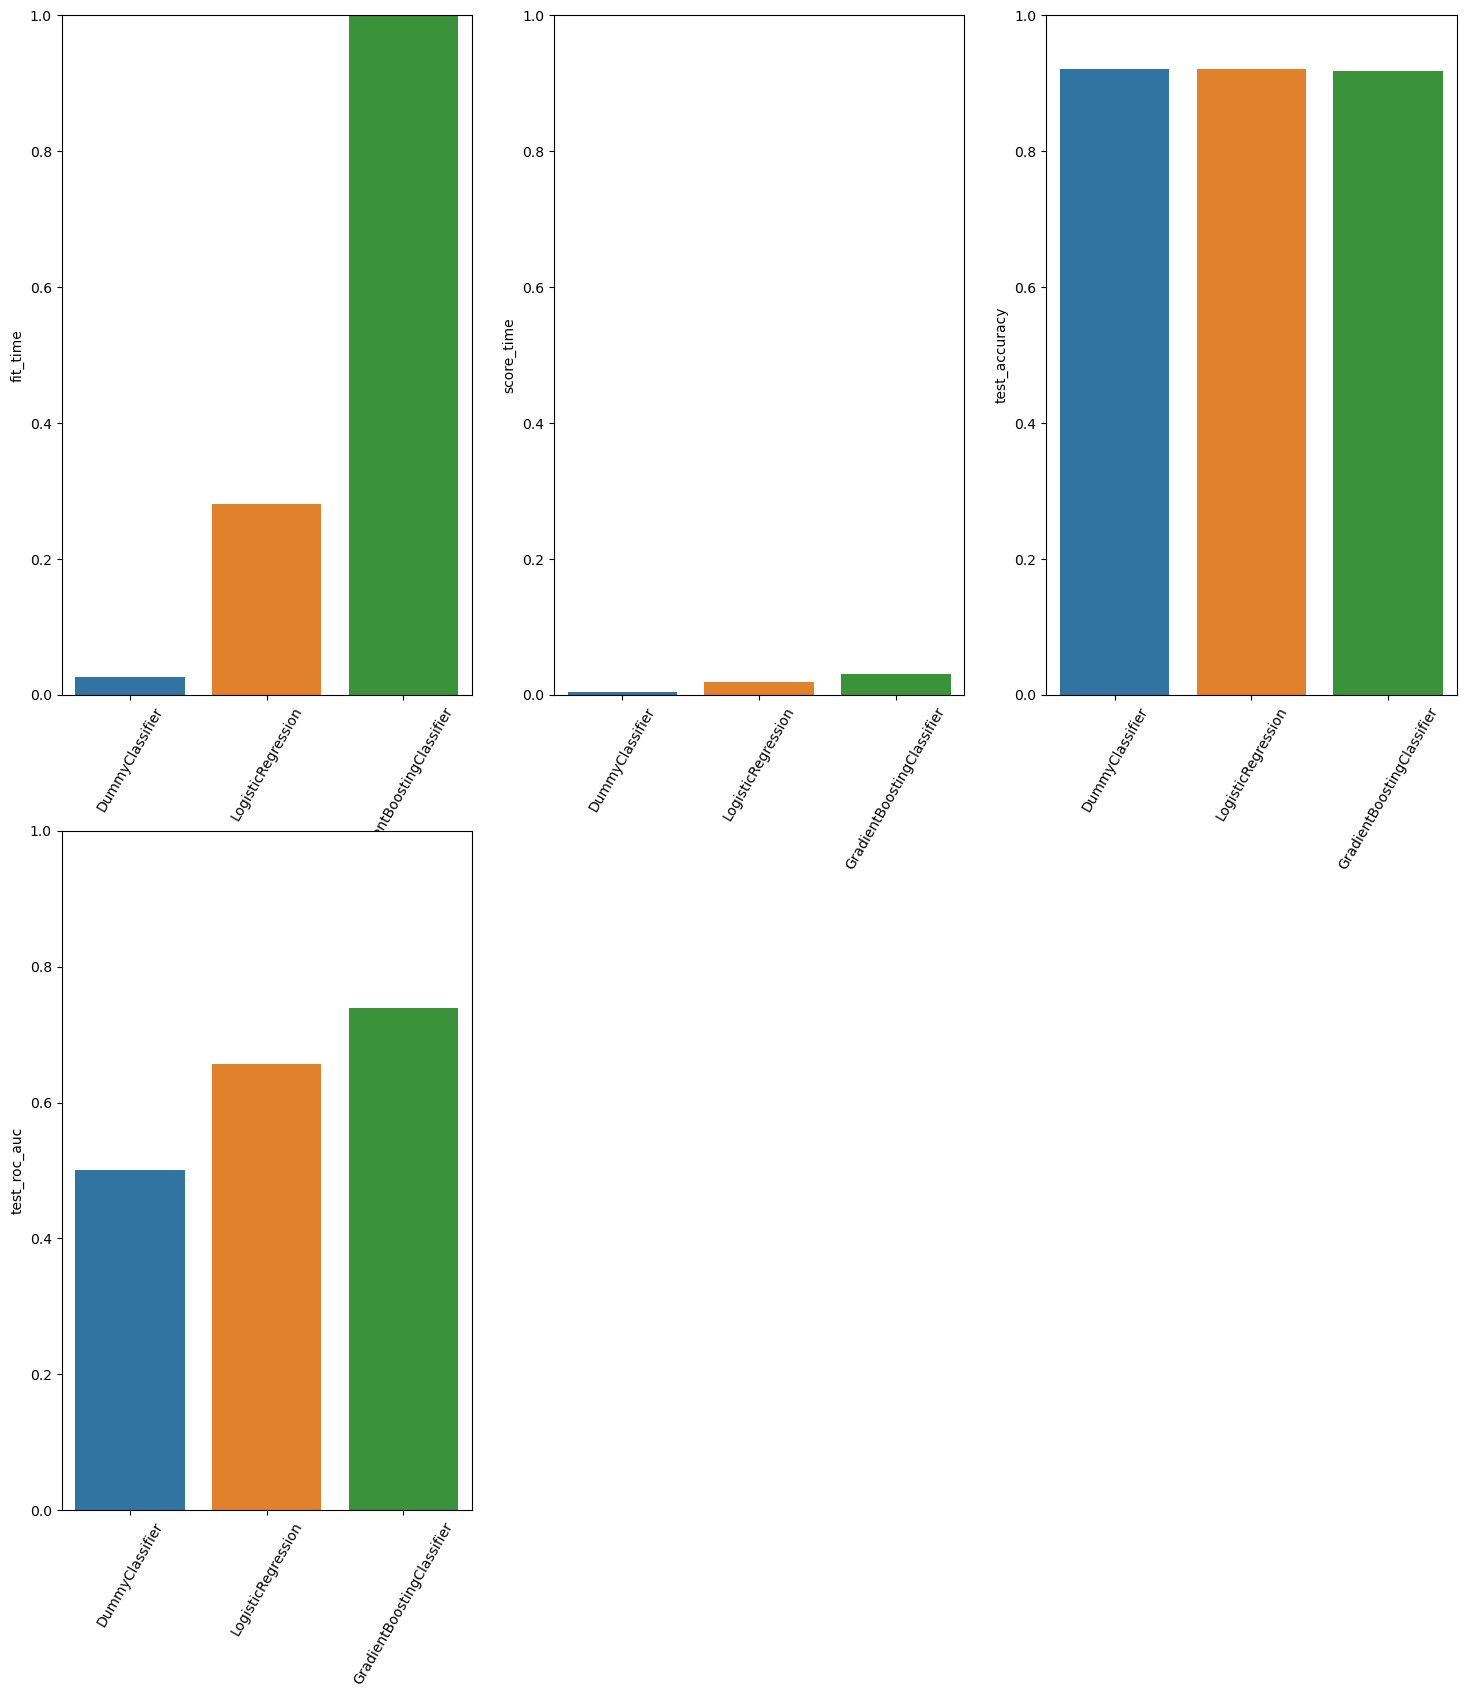

In [42]:
# Graph of the result of the cross validation
plt.figure(figsize=(18,30))
metric = list(resultats.keys())
for i in range(len(metric)):
    plt.subplot(3,3,i+1)
    sns.barplot(x=df_scores.index , y=df_scores[metric[i]])
    plt.xticks(rotation=60)
    plt.ylim((0,1))
plt.savefig('pred.png')
plt.show()

In [43]:
## lgbm ?? -> light gradient boost

In [44]:
import mlflow

In [45]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tracking")

<Experiment: artifact_location='file:///C:/Users/houda/Documents/Projet_OC/Projet7/mlruns/2', creation_time=1699626265279, experiment_id='2', last_update_time=1699626265279, lifecycle_stage='active', name='tracking', tags={}>

In [46]:
df_scores.index

Index(['DummyClassifier', 'LogisticRegression', 'GradientBoostingClassifier'], dtype='object')

In [47]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='DummyClassifier'):
    mlflow.set_tag("model_name", "DummyClassifier")
    
    DC = DummyClassifier()

    mlflow.log_metric("test_roc_auc", df_scores.loc['DummyClassifier', 'test_roc_auc'])
    mlflow.sklearn.log_model(DC, "sk_models")

2023/11/10 17:32:51 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

C:\Users\houda\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
